In [1]:
from xai import *
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from tqdm import tqdm

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
latent_dim = 8

try:
    mnist = MNIST.load("mnist.model")
except FileNotFoundError:
    mnist = MNIST(
        latent_shape=(latent_dim,), 
        hidden_layers=2, 
        classifier_head_output_activation="Softmax",
        ) 
    
    mnist.fit_autoencoder(
        epochs=10_000,
        batch_size=256,
        loss_criterion="MSELoss",
        early_stop_cont=750,
        verbose=True,
        info="Mnist autoencoder train"
    )

    mnist.fit_classifier_head(
        epochs=10_000,
        batch_size=256,
        early_stop_cont=750,
        verbose=True,
        info="Mnist classifier-head train"
    )

    mnist.save("mnist.model")
    

Early stopping! Train-loss: 0.013812, Val-loss: 0.015518:  55%|█████▌    | 5522/10000 [02:44<02:13, 33.52it/s]
Early stopping! Train-loss: -0.773225, Val-loss: -0.819443:  29%|██▉       | 2881/10000 [00:18<00:44, 159.83it/s]


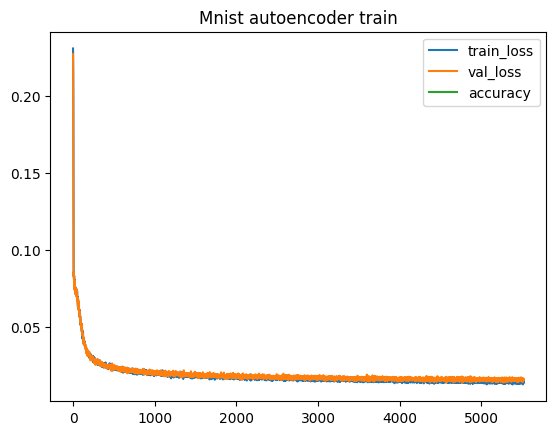

In [5]:
mnist.autoencoder.train_history.figure("Mnist autoencoder train")

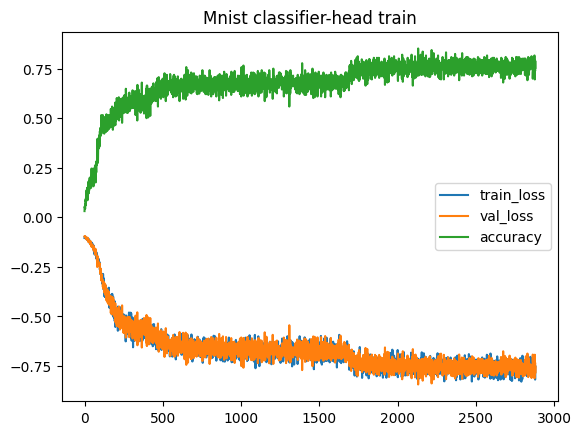

In [6]:
mnist.classifier_head.train_history.figure("Mnist classifier-head train")

In [8]:
save_folder = "images/mnist-autoencoder-v2"
samples = []
rows = 10
for i in range(rows):
    samples.append(mnist.get_sample(digit=i))

PermutationExplainer: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


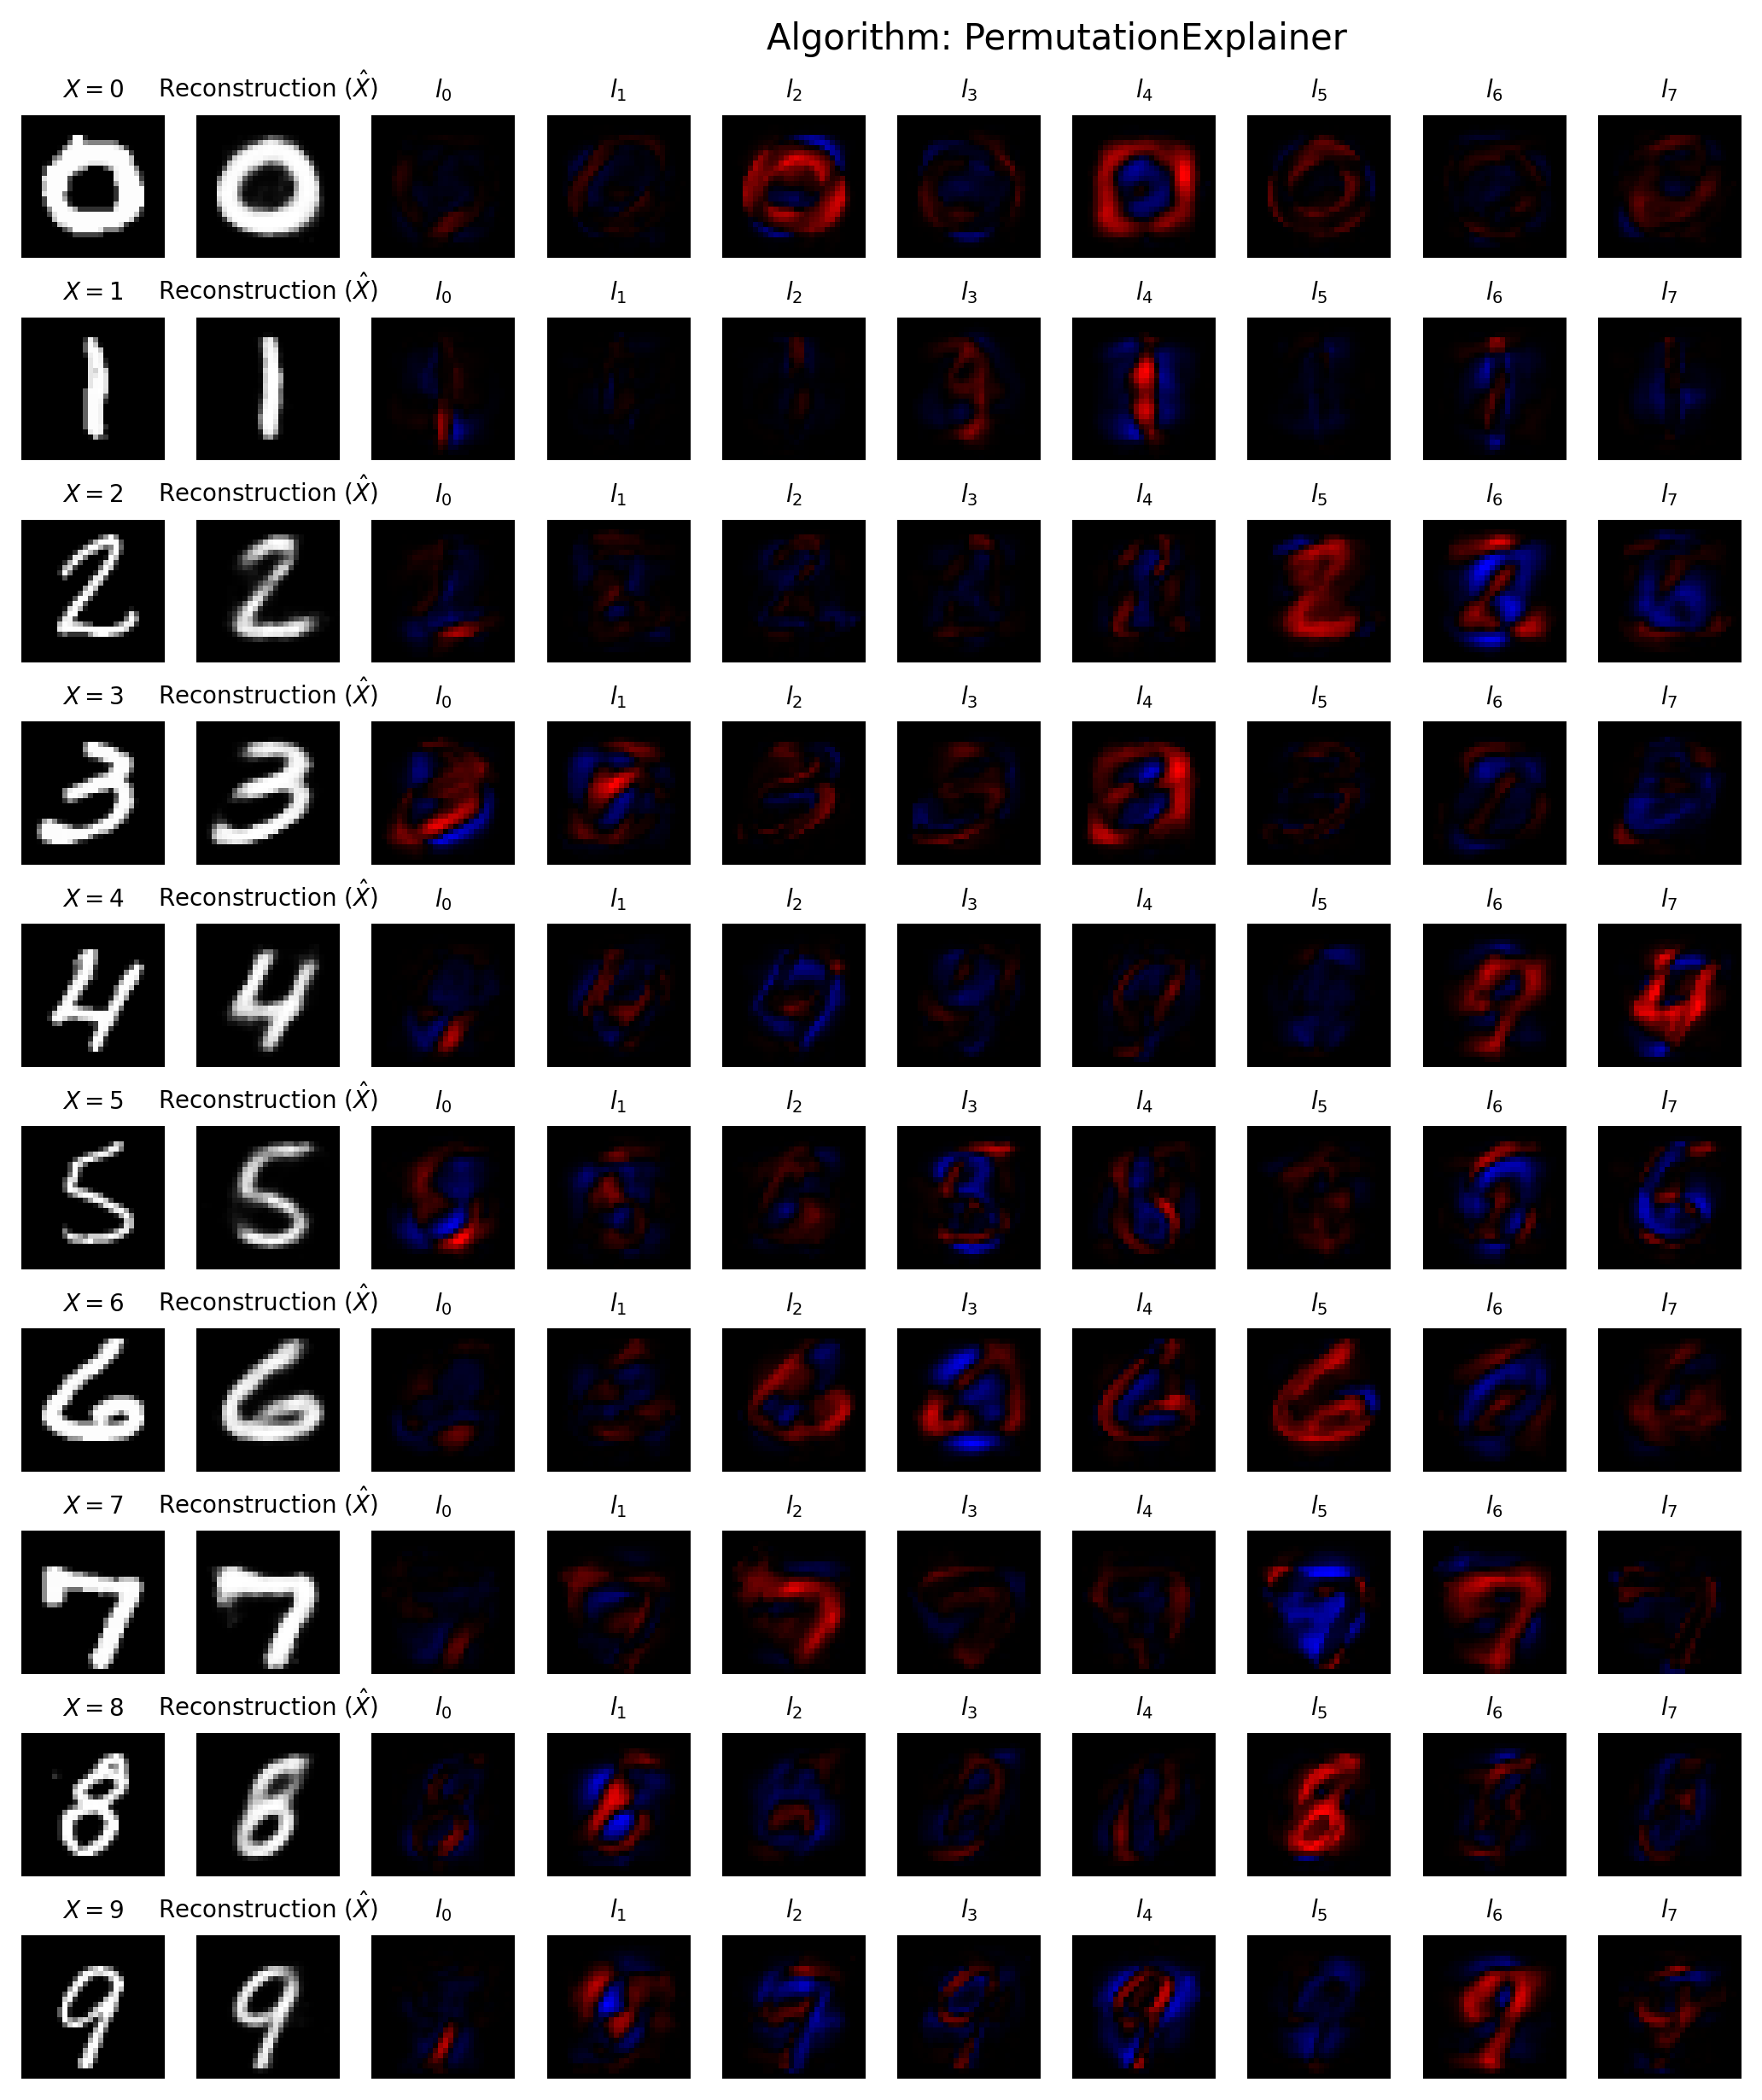

In [5]:
def mk_shap_latent_plot(algorithm: Explainers):
    fig = plt.figure(dpi=250, figsize=(10,10)) 
    fig.suptitle(f"Algorithm: {algorithm.capitalize()}Explainer")
    columns = latent_dim + 4

    with tqdm(total=rows, desc=f"{algorithm.capitalize()}Explainer") as bar:
        for row in range(rows):
            slot = row*columns

            sample,label = samples[row]
            sample = sample.numpy(force=True)
            label = int(label.item())
            predict = mnist(sample)
            recon = predict.reconstruction().numpy(force=True)

            recon_shap = predict.reconstruction.explain(algorithm, mnist(mnist.val_data).embedding()).invert().shap_values
            norm = max([np.max(np.abs(recon_shap))])


            fig.add_subplot(rows,columns,slot+1)
            plt.imshow(sample, cmap="gray")
            plt.axis('off')
            plt.title(f"$X={{{label}}}$", size=8)
                
            fig.add_subplot(rows,columns,slot+2)
            plt.imshow(recon, cmap="gray")
            plt.axis('off')
            plt.title("Reconstruction ($\hat{{X}}$)", size=8)

            for j,shap in enumerate(recon_shap):
                fig.add_subplot(rows,columns,slot+j+3)
                im = np.zeros((28,28,3), dtype=np.float32)
                red = np.where(shap > 0, shap/norm, np.zeros_like(shap))
                blue = np.where(shap < 0, -shap/norm, np.zeros_like(shap))
                im[:,:,0] = red
                im[:,:,2] = blue
                plt.imshow(im)
                plt.axis('off')
                plt.title(f"$l_{{{j}}}$", size=8)
            
            bar.update()

    fig.tight_layout()
    fig.savefig(f"{save_folder}/{algorithm}-shap-latents.png", bbox_inches="tight")




algorithm: Explainers
for algorithm in ["exact", "permutation", "deep", "kernel", "gradient"]:
    mk_shap_latent_plot(algorithm)

In [ ]:
def mk_combo_shap_classification_plot(algorithm: Explainers):
    fig = plt.figure(figsize=(19,17), dpi=250) 
    fig.suptitle(f"Algorithm: {algorithm.capitalize()}Explainer")
    rows = 10
    columns = 15

    with tqdm(total=rows, desc=f"{algorithm.capitalize()}Explainer") as bar:
        for row in range(rows):
            slot = row*columns

            sample,label = sample,label = samples[row]
            sample = sample.numpy(force=True)
            label = int(label.item())
            predict = mnist(sample)
            probabilities = predict.classification().tolist()
            recon = predict.reconstruction().numpy(force=True)

            fig.add_subplot(rows,columns,slot+1)
            plt.imshow(sample, cmap="gray")
            plt.axis('off')
            plt.title(f"Original ($X={{{label}}}$)", size=8)
                
            fig.add_subplot(rows,columns,slot+2)
            plt.imshow(recon, cmap="gray")
            plt.axis('off')
            plt.title("Reconstruction ($\hat{{X}}$)", size=8)

            recon_shap = predict.reconstruction.explain(algorithm, mnist(mnist.val_data).embedding())
            cls_shap = predict.classification.explain(algorithm, mnist(mnist.val_data).embedding())

            combined_shap = cls_shap.combine(recon_shap).shap_values
            
            delta_shap: np.ndarray = combined_shap[label] - (combined_shap[:label].sum(axis=0) + combined_shap[label+1:].sum(axis=0))
            shap_sum: np.ndarray = combined_shap.sum(axis=0)
            norm = max([np.max(np.abs(combined_shap)), np.max(np.abs(delta_shap)), np.max(np.abs(shap_sum))])

            for j,shap in enumerate(combined_shap):
                fig.add_subplot(rows,columns,slot+j+3)
                im = np.zeros((28,28,3), dtype=np.float32)
                red = np.where(shap > 0, shap/norm, np.zeros_like(shap))
                blue = np.where(shap < 0, -shap/norm, np.zeros_like(shap))
                im[:,:,0] = red
                im[:,:,2] = blue
                plt.imshow(im)
                plt.axis('off')
                plt.title(f"Class: {j} ($C_{j}$)\n${probabilities[j]*100:.2f}$%", size=8)

            
            fig.add_subplot(rows,columns,slot+j+4)
            im = np.zeros((28,28,3), dtype=np.float32)
            red = np.where(shap_sum > 0, shap_sum/norm, np.zeros_like(shap_sum))
            blue = np.where(shap_sum < 0, -shap_sum/norm, np.zeros_like(shap_sum))
            im[:,:,0] = red
            im[:,:,2] = blue
            plt.imshow(im)
            plt.axis('off')
            sum_all_shap = round(shap_sum.sum(), ndigits=5)
            plt.title(f"$\sum_{{i={0}}}^{{{rows-1}}}{{C_i}}={{{sum_all_shap}}}$", size=8)

            fig.add_subplot(rows,columns,slot+j+5)
            im = np.zeros((28,28,3), dtype=np.float32)
            red = np.where(delta_shap > 0, delta_shap/norm, np.zeros_like(delta_shap))
            blue = np.where(delta_shap < 0, -delta_shap/norm, np.zeros_like(delta_shap))
            im[:,:,0] = red
            im[:,:,2] = blue
            plt.imshow(im)
            plt.axis('off')
            if row == 0:
                plt.title(f"$C_{{{label}}} - \sum_{{i={1}}}^{{{rows-1}}}{{C_i}}$", size=8)
            elif row == (rows - 1):
                plt.title(f"$C_{{{label}}} - \sum_{{i={0}}}^{{{rows-2}}}{{C_i}}$", size=8)
            else:
                plt.title(f"$C_{{{label}}} - (\sum_{{i={0}}}^{{{label-1}}}{{C_i}} + \sum_{{i={label+1}}}^{{{rows-1}}}{{C_i}})$", size=8)

            bar.update()

    fig.tight_layout()
    fig.savefig(f"{save_folder}/{algorithm}-shap-digits.png", bbox_inches="tight")



algorithm: Explainers
for algorithm in ["exact", "permutation", "deep", "kernel", "gradient"]:
    mk_combo_shap_classification_plot(algorithm)

In [ ]:
def mk_normal_shap_classification_plot(algorithm: Explainers, max_evals: int|None = None):
    fig = plt.figure(figsize=(19,17), dpi=250) 
    fig.suptitle(f"Algorithm: {algorithm.capitalize()}Explainer")
    rows = 10
    columns = 15

    classifier = mnist.autoencoder.encoder + mnist.classifier_head
    explainer = classifier.explainer(algorithm, mnist.val_data)

    with tqdm(total=rows, desc=f"{algorithm.capitalize()}Explainer") as bar:
        for row in range(rows):
            slot = row*columns

            sample,label = sample,label = samples[row]
            sample = sample.numpy(force=True)
            label = int(label.item())
            predict = mnist(sample)
            probabilities = predict.classification().tolist()
            recon = predict.reconstruction().numpy(force=True)

            fig.add_subplot(rows,columns,slot+1)
            plt.imshow(sample, cmap="gray")
            plt.axis('off')
            plt.title(f"Original ($X={{{label}}}$)", size=8)
                
            fig.add_subplot(rows,columns,slot+2)
            plt.imshow(recon, cmap="gray")
            plt.axis('off')
            plt.title("Reconstruction ($\hat{{X}}$)", size=8)

            shap_explanation = explainer.explain(sample, max_evals=max_evals).item().shap_values
            
            delta_shap: np.ndarray = shap_explanation[label] - (shap_explanation[:label].sum(axis=0) + shap_explanation[label+1:].sum(axis=0))
            shap_sum: np.ndarray = shap_explanation.sum(axis=0)
            norm = max([np.max(np.abs(shap_explanation)), np.max(np.abs(delta_shap)), np.max(np.abs(shap_sum))])

            for j,explanation in enumerate(shap_explanation):
                fig.add_subplot(rows,columns,slot+j+3)
                im = np.zeros((28,28,3), dtype=np.float32)
                red = np.where(explanation > 0, explanation/norm, np.zeros_like(explanation))
                blue = np.where(explanation < 0, -explanation/norm, np.zeros_like(explanation))
                im[:,:,0] = red
                im[:,:,2] = blue
                plt.imshow(im)
                plt.axis('off')
                plt.title(f"Class: {j} ($C_{j}$)\n${probabilities[j]*100:.2f}$%", size=8)

            
            fig.add_subplot(rows,columns,slot+j+4)
            im = np.zeros((28,28,3), dtype=np.float32)
            red = np.where(shap_sum > 0, shap_sum/norm, np.zeros_like(shap_sum))
            blue = np.where(shap_sum < 0, -shap_sum/norm, np.zeros_like(shap_sum))
            im[:,:,0] = red
            im[:,:,2] = blue
            plt.imshow(im)
            plt.axis('off')
            sum_all_shap = round(shap_sum.sum(), ndigits=5)
            plt.title(f"$\sum_{{i={0}}}^{{{rows-1}}}{{C_i}}={{{sum_all_shap}}}$", size=8)

            fig.add_subplot(rows,columns,slot+j+5)
            im = np.zeros((28,28,3), dtype=np.float32)
            red = np.where(delta_shap > 0, delta_shap/norm, np.zeros_like(delta_shap))
            blue = np.where(delta_shap < 0, -delta_shap/norm, np.zeros_like(delta_shap))
            im[:,:,0] = red
            im[:,:,2] = blue
            plt.imshow(im)
            plt.axis('off')
            if row == 0:
                plt.title(f"$C_{{{label}}} - \sum_{{i={1}}}^{{{rows-1}}}{{C_i}}$", size=8)
            elif row == (rows - 1):
                plt.title(f"$C_{{{label}}} - \sum_{{i={0}}}^{{{rows-2}}}{{C_i}}$", size=8)
            else:
                plt.title(f"$C_{{{label}}} - (\sum_{{i={0}}}^{{{label-1}}}{{C_i}} + \sum_{{i={label+1}}}^{{{rows-1}}}{{C_i}})$", size=8)

            bar.update()

    fig.tight_layout()
    fig.savefig(f"{save_folder}/{algorithm}-normal-shap-digits.png", bbox_inches="tight")

algorithm: Explainers
for algorithm in ["gradient"]:
    mk_normal_shap_classification_plot(algorithm, max_evals=150_000)

In [ ]:
def mk_normal_and_recon_shap_plot(algorithm: Explainers, figsize: Tuple[int,int]):
    fig = plt.figure(dpi=250, figsize=figsize) 
    fig.suptitle(f"Algorithm: {algorithm.capitalize()}Explainer")
    columns = 4 + latent_dim*2

    encoder = mnist.autoencoder.encoder
    decoder = mnist.autoencoder.decoder

    encoder_explainer = encoder.explainer(algorithm, mnist.val_data)
    decoder_explainer = decoder.explainer(algorithm, encoder(mnist.val_data).output())

    i = 1
    def add_subplot():
        nonlocal i
        fig.add_subplot(rows,columns,i)
        i += 1

    with tqdm(total=rows, desc=f"{algorithm.capitalize()}Explainer") as bar:
        for row in range(rows):

            sample,label = samples[row]
            sample = sample.numpy(force=True)
            label = int(label.item())
            predict = mnist(sample)

            embedding = predict.embedding()
            reconstruction = predict.reconstruction().numpy(force=True)

            encoder_shap = encoder_explainer.explain(sample, max_evals=None).item().shap_values
            decoder_shap = np.moveaxis(decoder_explainer.explain(embedding).item().shap_values, 2, 0)

            #norm = max([np.max(np.abs(encoder_shap)), np.max(np.abs(decoder_shap))])
            encoder_shap_sum = encoder_shap.sum(axis=0)
            decoder_shap_sum = decoder_shap.sum(axis=0)

            encoder_norm = max([np.max(np.abs(encoder_shap)), np.max(np.abs(encoder_shap_sum))])
            decoder_norm = max([np.max(np.abs(decoder_shap)), np.max(np.abs(decoder_shap_sum))])

            add_subplot()
            plt.imshow(sample, cmap="gray")
            plt.axis('off')
            plt.title(f"$X={{{label}}}$", size=8)
                
            add_subplot()
            plt.imshow(reconstruction, cmap="gray")
            plt.axis('off')
            plt.title("$\hat{{X}}$", size=8)

            #print(encoder_shap_weights.sum() - decoder_shap_weights.sum())

            for j,(encoder_latent, decoder_latent) in enumerate(zip(encoder_shap, decoder_shap)):
                add_subplot()
                im = np.zeros((28,28,3), dtype=np.float32)
                red = np.where(encoder_latent > 0, encoder_latent/encoder_norm, np.zeros_like(encoder_latent))
                blue = np.where(encoder_latent < 0, -encoder_latent/encoder_norm, np.zeros_like(encoder_latent))
                im[:,:,0] = red
                im[:,:,2] = blue
                plt.imshow(im)
                plt.axis('off')
                plt.title(f"$E_{{l_{{{j}}}}}$", size=8)

                add_subplot()
                im = np.zeros((28,28,3), dtype=np.float32)
                red = np.where(decoder_latent > 0, decoder_latent/decoder_norm, np.zeros_like(decoder_latent))
                blue = np.where(decoder_latent < 0, -decoder_latent/decoder_norm, np.zeros_like(decoder_latent))
                im[:,:,0] = red
                im[:,:,2] = blue
                plt.imshow(im)
                plt.axis('off')
                plt.title(f"$D_{{l_{{{j}}}}}$", size=8)

            
            add_subplot()
            im = np.zeros((28,28,3), dtype=np.float32)
            red = np.where(encoder_shap_sum > 0, encoder_shap_sum/encoder_norm, np.zeros_like(encoder_shap_sum))
            blue = np.where(encoder_shap_sum < 0, -encoder_shap_sum/encoder_norm, np.zeros_like(encoder_shap_sum))
            im[:,:,0] = red
            im[:,:,2] = blue
            plt.imshow(im)
            plt.axis('off')
            plt.title(f"$\sum_{{i={0}}}^{{{rows-1}}}{{E_{{l_i}}}}$", size=8)

            add_subplot()
            im = np.zeros((28,28,3), dtype=np.float32)
            red = np.where(decoder_shap_sum > 0, decoder_shap_sum/decoder_norm, np.zeros_like(decoder_shap_sum))
            blue = np.where(decoder_shap_sum < 0, -decoder_shap_sum/decoder_norm, np.zeros_like(decoder_shap_sum))
            im[:,:,0] = red
            im[:,:,2] = blue
            plt.imshow(im)
            plt.axis('off')
            plt.title(f"$\sum_{{i={0}}}^{{{rows-1}}}{{D_{{l_i}}}}$", size=8)
            
            bar.update()

    fig.tight_layout(w_pad=0.3)
    #fig.savefig(f"{save_folder}/{algorithm}-shap-latents.png", bbox_inches="tight")

algorithm: Explainers
for algorithm in ["permutation"]:
    mk_normal_and_recon_shap_plot(algorithm, figsize=(17,11))

In [ ]:
def mk_normal_and_inverse_shap_plot(algorithm: Explainers, figsize: Tuple[int,int]):
    fig = plt.figure(dpi=250, figsize=figsize) 
    fig.suptitle(f"Algorithm: {algorithm.capitalize()}Explainer")
    columns = 4 + latent_dim*2

    encoder = mnist.autoencoder.encoder
    decoder = mnist.autoencoder.decoder

    encoder_explainer = encoder.explainer(algorithm, mnist.val_data)
    decoder_explainer = decoder.explainer(algorithm, encoder_explainer.base_values)

    i = 1
    def add_subplot():
        nonlocal i
        fig.add_subplot(rows,columns,i)
        i += 1

    with tqdm(total=rows, desc=f"{algorithm.capitalize()}Explainer") as bar:
        for row in range(rows):

            sample,label = samples[row]
            sample = sample.numpy(force=True)
            label = int(label.item())
            predict = mnist(sample)

            embedding = predict.embedding()
            reconstruction = predict.reconstruction().numpy(force=True)

            encoder_shap = encoder_explainer.explain(sample, max_evals=None).item().shap_values
            decoder_shap = np.moveaxis(decoder_explainer.explain(embedding).item().shap_values, 2, 0)

            #norm = max([np.max(np.abs(encoder_shap)), np.max(np.abs(decoder_shap))])
            encoder_shap_sum = encoder_shap.sum(axis=0)
            decoder_shap_sum = decoder_shap.sum(axis=0)

            encoder_norm = max([np.max(np.abs(encoder_shap)), np.max(np.abs(encoder_shap_sum))])
            decoder_norm = max([np.max(np.abs(decoder_shap)), np.max(np.abs(decoder_shap_sum))])

            add_subplot()
            plt.imshow(sample, cmap="gray")
            plt.axis('off')
            plt.title(f"$X={{{label}}}$", size=8)
                
            add_subplot()
            plt.imshow(reconstruction, cmap="gray")
            plt.axis('off')
            plt.title("$\hat{{X}}$", size=8)

            prediction = predict.embedding().numpy(force=True)
            mean_prediction = encoder_explainer.base_values
            inverse_shap = np.zeros_like(decoder_shap)

            for l in range(latent_dim):
                shap_abs = np.abs(decoder_shap[l])
                inverse_shap[l] = (shap_abs/np.sum(shap_abs))*(prediction[l] - mean_prediction[l])

            inverse_shap_sum = inverse_shap.sum(axis=0)
            inverse_norm = max([np.max(np.abs(inverse_shap)), np.max(np.abs(inverse_shap_sum))])

            #print(encoder_shap_weights.sum() - decoder_shap_weights.sum())

            for j,(encoder_latent, inverse_latent) in enumerate(zip(encoder_shap, inverse_shap)):
                add_subplot()
                im = np.zeros((28,28,3), dtype=np.float32)
                red = np.where(encoder_latent > 0, encoder_latent/encoder_norm, np.zeros_like(encoder_latent))
                blue = np.where(encoder_latent < 0, -encoder_latent/encoder_norm, np.zeros_like(encoder_latent))
                im[:,:,0] = red
                im[:,:,2] = blue
                plt.imshow(im)
                plt.axis('off')
                plt.title(f"$E_{{l_{{{j}}}}}$", size=8)

                add_subplot()
                im = np.zeros((28,28,3), dtype=np.float32)
                red = np.where(inverse_latent > 0, inverse_latent/inverse_norm, np.zeros_like(inverse_latent))
                blue = np.where(inverse_latent < 0, -inverse_latent/inverse_norm, np.zeros_like(inverse_latent))
                im[:,:,0] = red
                im[:,:,2] = blue
                plt.imshow(im)
                plt.axis('off')
                plt.title(f"$D_{{l_{{{j}}}}}$", size=8)

            
            add_subplot()
            im = np.zeros((28,28,3), dtype=np.float32)
            red = np.where(encoder_shap_sum > 0, encoder_shap_sum/encoder_norm, np.zeros_like(encoder_shap_sum))
            blue = np.where(encoder_shap_sum < 0, -encoder_shap_sum/encoder_norm, np.zeros_like(encoder_shap_sum))
            im[:,:,0] = red
            im[:,:,2] = blue
            plt.imshow(im)
            plt.axis('off')
            plt.title(f"$\sum_{{i={0}}}^{{{rows-1}}}{{E_{{l_i}}}}$", size=8)

            add_subplot()
            im = np.zeros((28,28,3), dtype=np.float32)
            red = np.where(inverse_shap_sum > 0, inverse_shap_sum/inverse_norm, np.zeros_like(inverse_shap_sum))
            blue = np.where(inverse_shap_sum < 0, -inverse_shap_sum/inverse_norm, np.zeros_like(inverse_shap_sum))
            im[:,:,0] = red
            im[:,:,2] = blue
            plt.imshow(im)
            plt.axis('off')
            plt.title(f"$\sum_{{i={0}}}^{{{rows-1}}}{{D_{{l_i}}}}$", size=8)
            
            bar.update()

    fig.tight_layout(w_pad=0.3)
    #fig.savefig(f"{save_folder}/{algorithm}-shap-latents.png", bbox_inches="tight")

algorithm: Explainers
for algorithm in ["permutation"]:
    mk_normal_and_inverse_shap_plot(algorithm, figsize=(17,11))

In [ ]:
def mk_combo_shap_classification_plot(algorithm: Explainers):
    fig = plt.figure(figsize=(19,17), dpi=250) 
    fig.suptitle(f"Algorithm: {algorithm.capitalize()}Explainer")
    rows = 10
    columns = 15

    with tqdm(total=rows, desc=f"{algorithm.capitalize()}Explainer") as bar:
        for row in range(rows):
            slot = row*columns

            sample,label = sample,label = samples[row]
            sample = sample.numpy(force=True)
            label = int(label.item())
            predict = mnist(sample)
            probabilities = predict.classification().tolist()
            embedding = predict.embedding()
            recon = predict.reconstruction().numpy(force=True)

            fig.add_subplot(rows,columns,slot+1)
            plt.imshow(sample, cmap="gray")
            plt.axis('off')
            plt.title(f"Original ($X={{{label}}}$)", size=8)
                
            fig.add_subplot(rows,columns,slot+2)
            plt.imshow(recon, cmap="gray")
            plt.axis('off')
            plt.title("Reconstruction ($\hat{{X}}$)", size=8)

            recon_shap = predict.reconstruction.explain(algorithm, mnist(mnist.val_data).embedding())
            recon_base = recon_shap.base_values
            recon_shap = recon_shap.shap_values.reshape((784,latent_dim))
            recon_weights = np.abs(recon_shap)/np.sum(np.abs(recon_shap))

            cls_shap = predict.classification.explain(algorithm, mnist(mnist.val_data).embedding())
            cls_base = cls_shap.base_values
            cls_shap = cls_shap.shap_values.reshape((10,latent_dim))

            combined_shap = np.zeros((10,784), dtype=np.float64)

            for l in range(latent_dim):
                weight_sum = np.sum(np.abs(recon_shap[:,l]))
                for d in range(10):
                    for p in range(784):
                        combined_shap[d,p] += np.abs(recon_shap[p,l])/weight_sum * cls_shap[d,l]

            combined_shap = combined_shap.reshape((10,28,28))

            print(combined_shap.sum())
            print(cls_shap.sum(), (predict.classification().numpy(force=True) - cls_base).sum())

            
            delta_shap: np.ndarray = combined_shap[label] - (combined_shap[:label].sum(axis=0) + combined_shap[label+1:].sum(axis=0))
            shap_sum: np.ndarray = combined_shap.sum(axis=0)
            norm = max([np.max(np.abs(combined_shap)), np.max(np.abs(delta_shap)), np.max(np.abs(shap_sum))])

            for j,shap in enumerate(combined_shap):
                fig.add_subplot(rows,columns,slot+j+3)
                im = np.zeros((28,28,3), dtype=np.float32)
                red = np.where(shap > 0, shap/norm, np.zeros_like(shap))
                blue = np.where(shap < 0, -shap/norm, np.zeros_like(shap))
                im[:,:,0] = red
                im[:,:,2] = blue
                plt.imshow(im)
                plt.axis('off')
                plt.title(f"Class: {j} ($C_{j}$)\n${probabilities[j]*100:.2f}$%", size=8)

            
            fig.add_subplot(rows,columns,slot+j+4)
            im = np.zeros((28,28,3), dtype=np.float32)
            red = np.where(shap_sum > 0, shap_sum/norm, np.zeros_like(shap_sum))
            blue = np.where(shap_sum < 0, -shap_sum/norm, np.zeros_like(shap_sum))
            im[:,:,0] = red
            im[:,:,2] = blue
            plt.imshow(im)
            plt.axis('off')
            sum_all_shap = round(shap_sum.sum(), ndigits=5)
            plt.title(f"$\sum_{{i={0}}}^{{{rows-1}}}{{C_i}}={{{sum_all_shap}}}$", size=8)

            fig.add_subplot(rows,columns,slot+j+5)
            im = np.zeros((28,28,3), dtype=np.float32)
            red = np.where(delta_shap > 0, delta_shap/norm, np.zeros_like(delta_shap))
            blue = np.where(delta_shap < 0, -delta_shap/norm, np.zeros_like(delta_shap))
            im[:,:,0] = red
            im[:,:,2] = blue
            plt.imshow(im)
            plt.axis('off')
            if row == 0:
                plt.title(f"$C_{{{label}}} - \sum_{{i={1}}}^{{{rows-1}}}{{C_i}}$", size=8)
            elif row == (rows - 1):
                plt.title(f"$C_{{{label}}} - \sum_{{i={0}}}^{{{rows-2}}}{{C_i}}$", size=8)
            else:
                plt.title(f"$C_{{{label}}} - (\sum_{{i={0}}}^{{{label-1}}}{{C_i}} + \sum_{{i={label+1}}}^{{{rows-1}}}{{C_i}})$", size=8)

            bar.update()

    fig.tight_layout()
    fig.savefig(f"{save_folder}/{algorithm}-shap-digits.png", bbox_inches="tight")



algorithm: Explainers
for algorithm in ["exact"]:
    mk_combo_shap_classification_plot(algorithm)